In [1]:
import pandas as pd
import numpy as np

import json

from scripts.utils import SimulateData
from stopsignalmetrics.ssrtmodel import SSRTmodel

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

## Suffix
### Indicates which set of results to view

In [2]:
suffix = 'SSRTscale-0_RTscale-0'

# SSRT by SSD

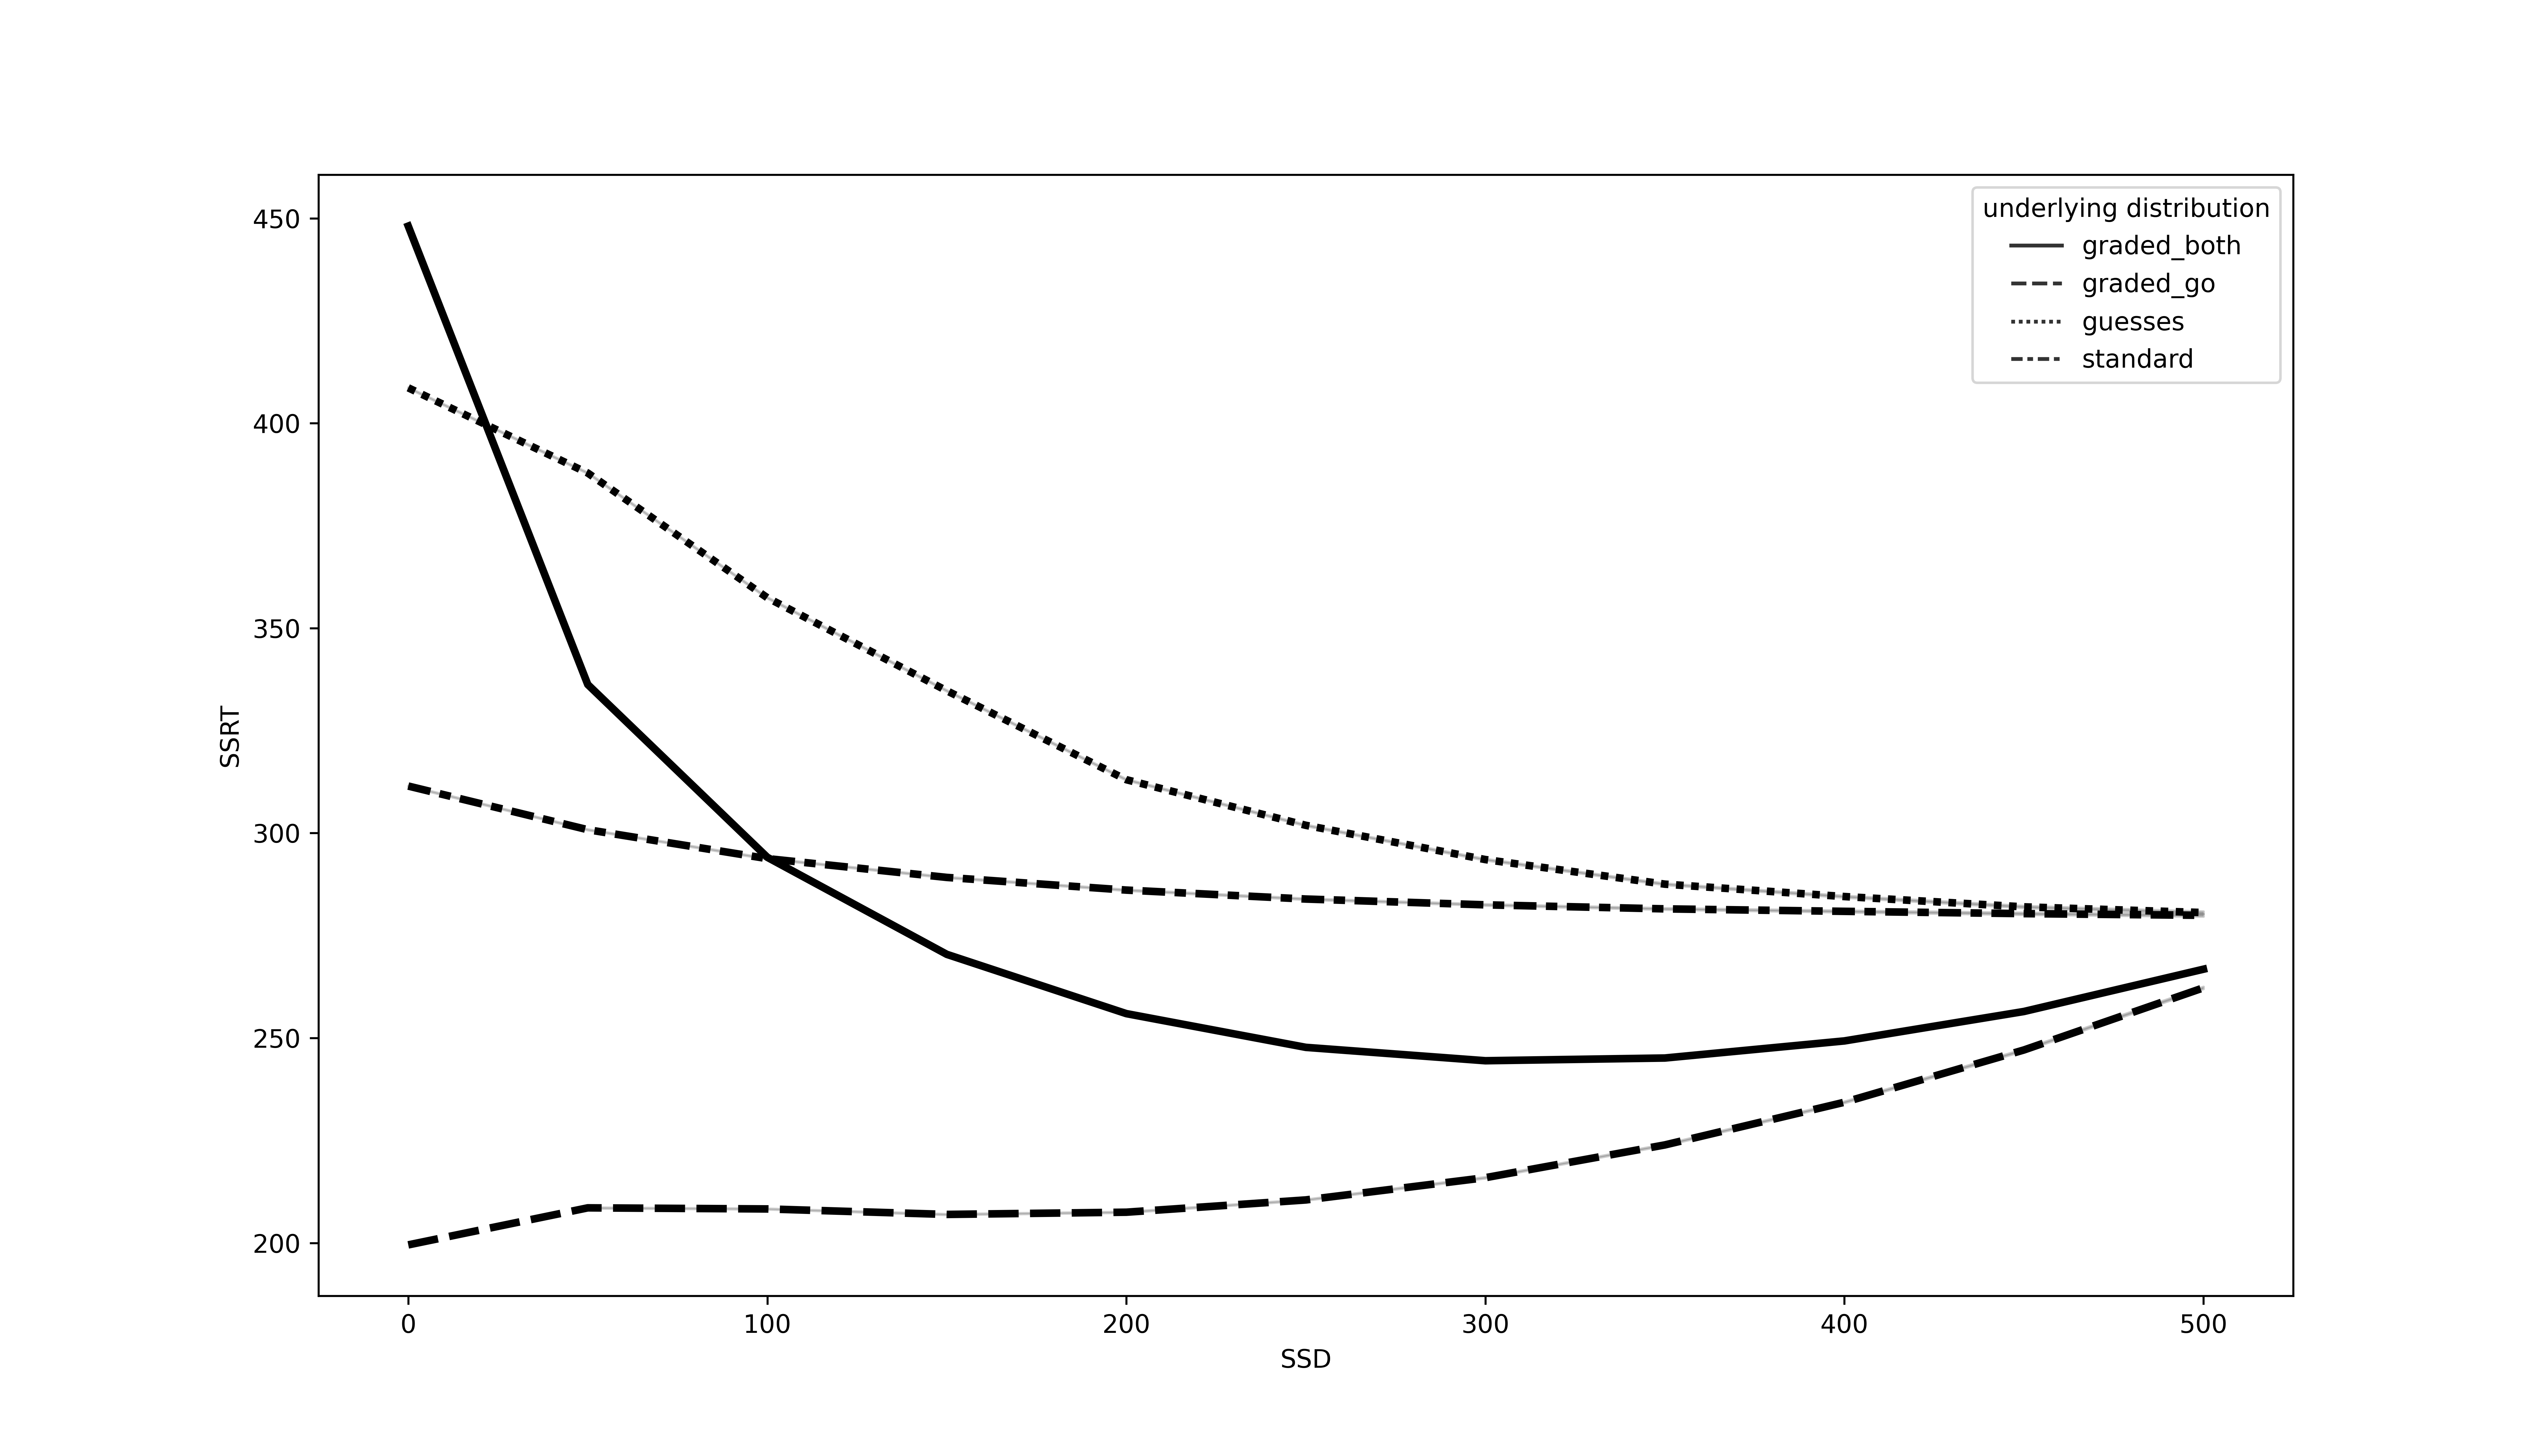

In [3]:
Image('figures/%s/SSRT_by_SSD.png' % suffix)

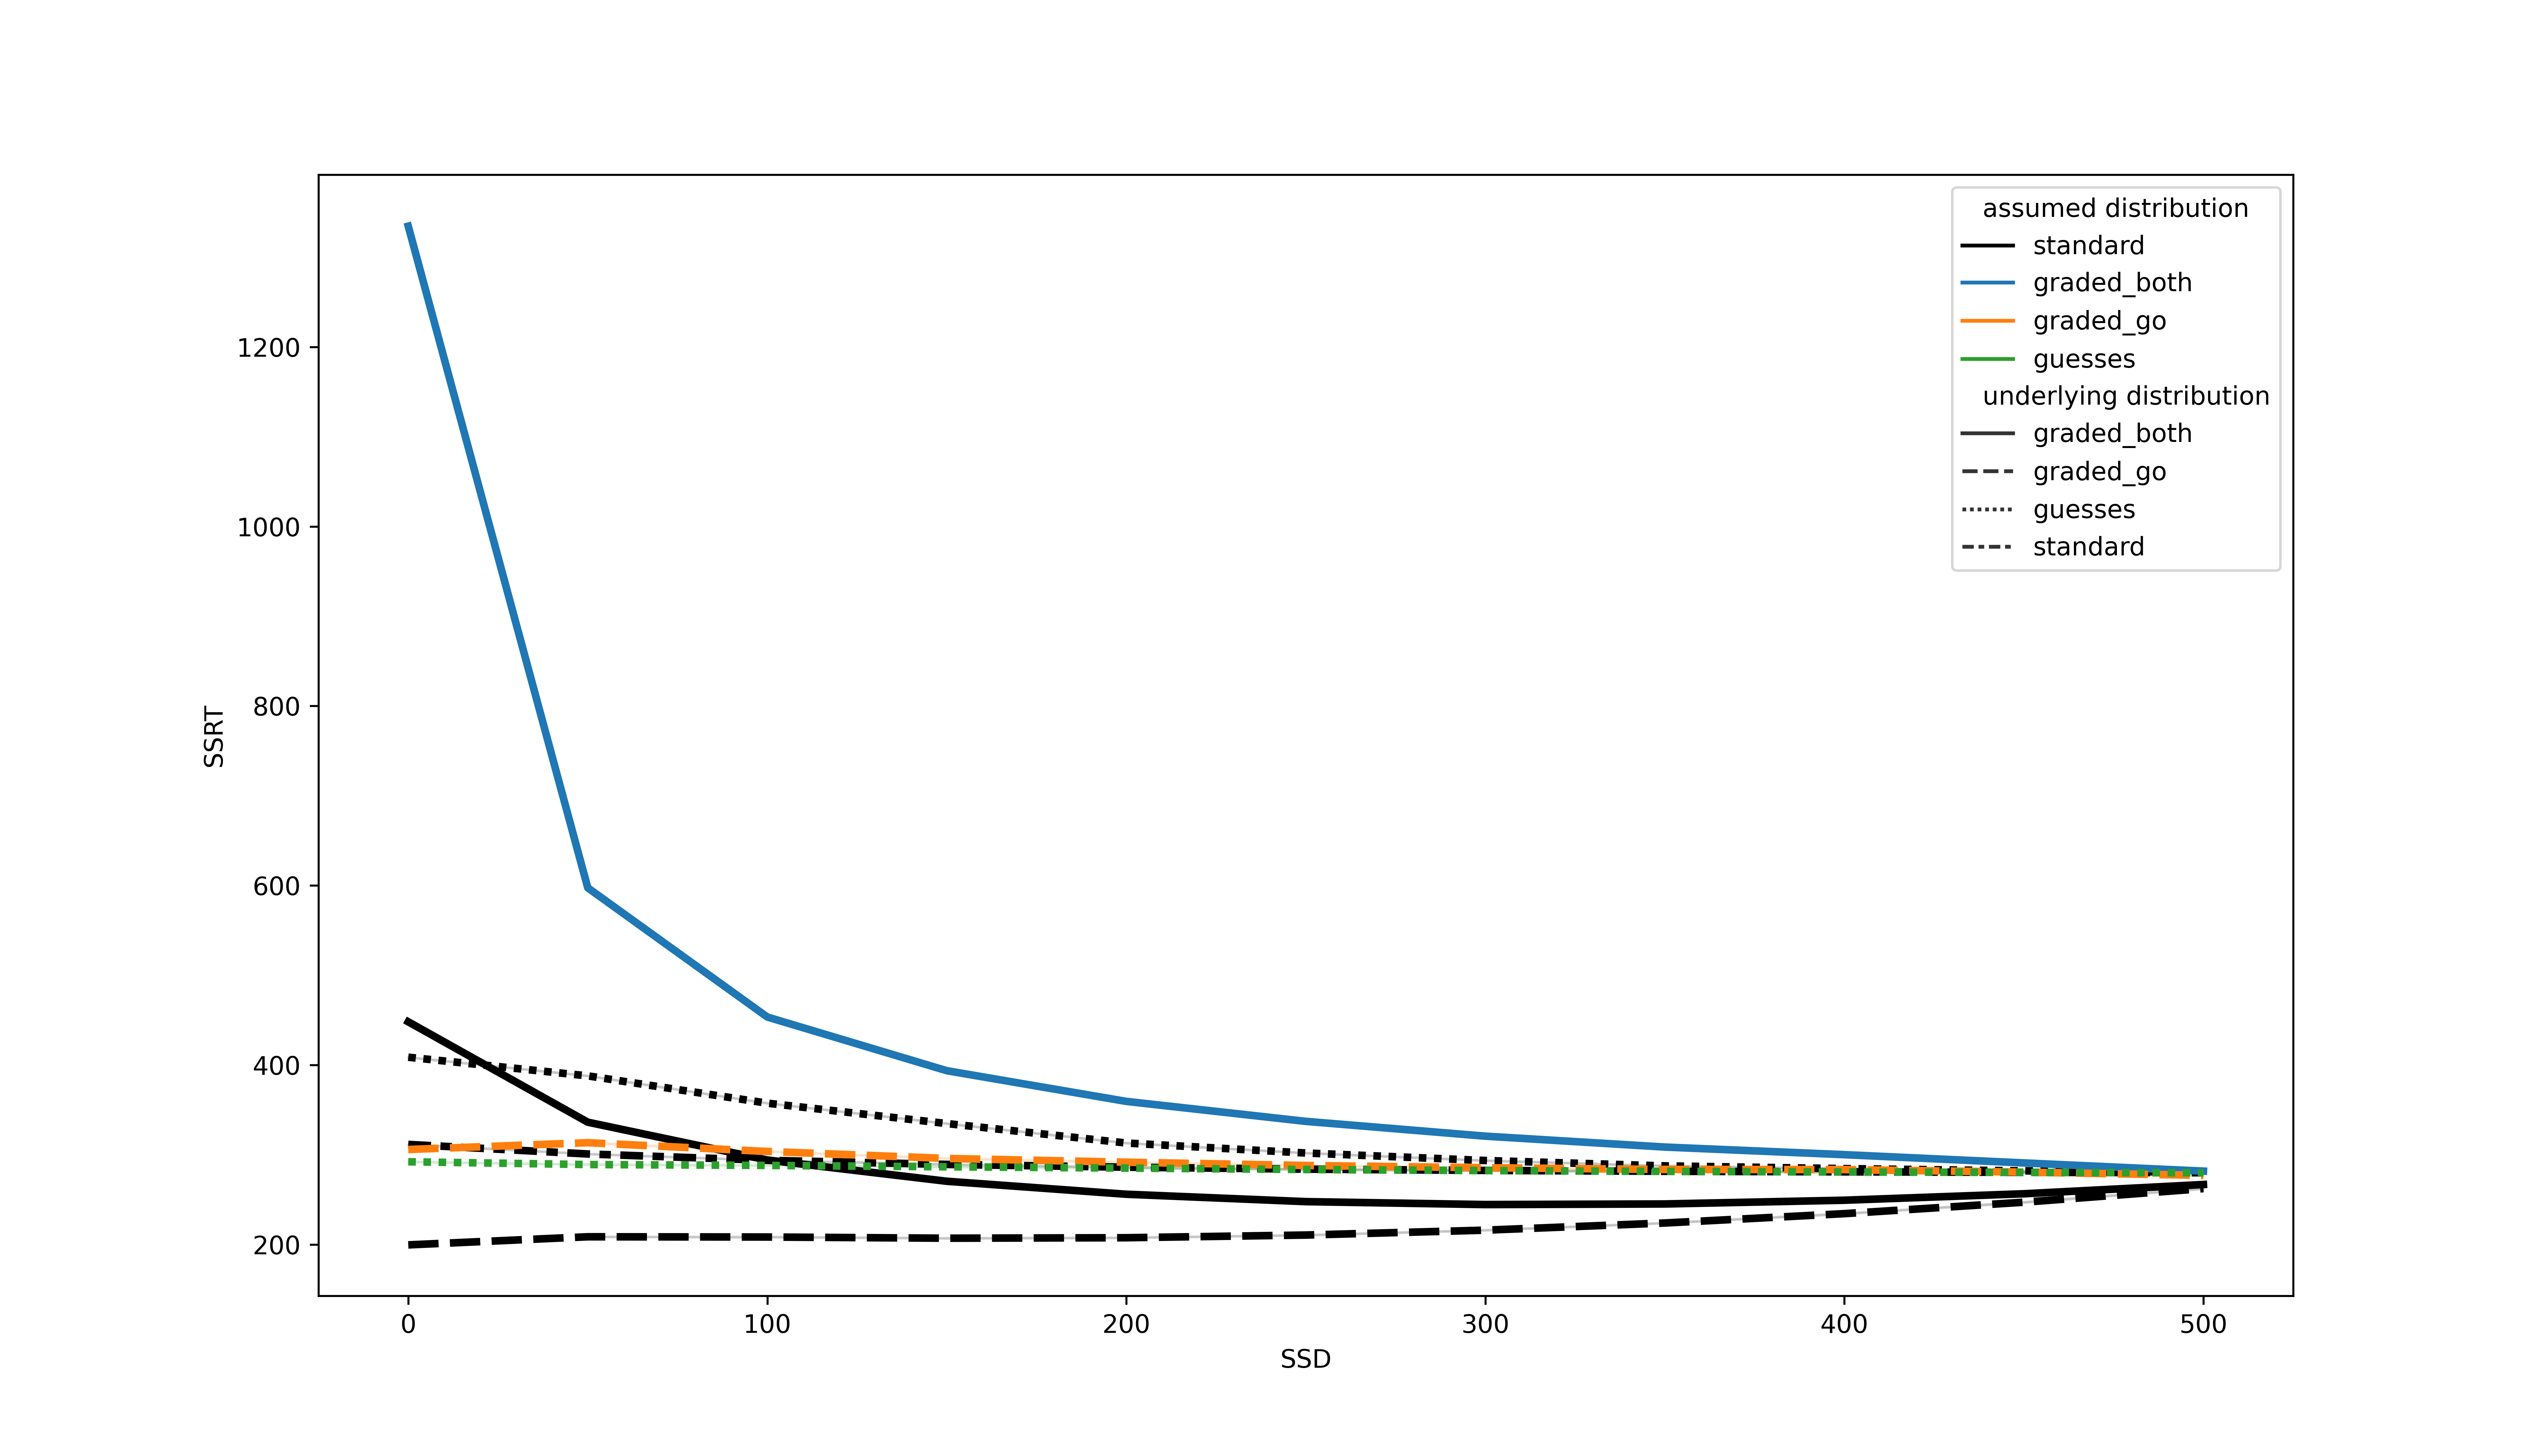

In [4]:
Image('figures/%s/SSRT_by_SSD_supplement.png' % suffix)

# Inhibition Function

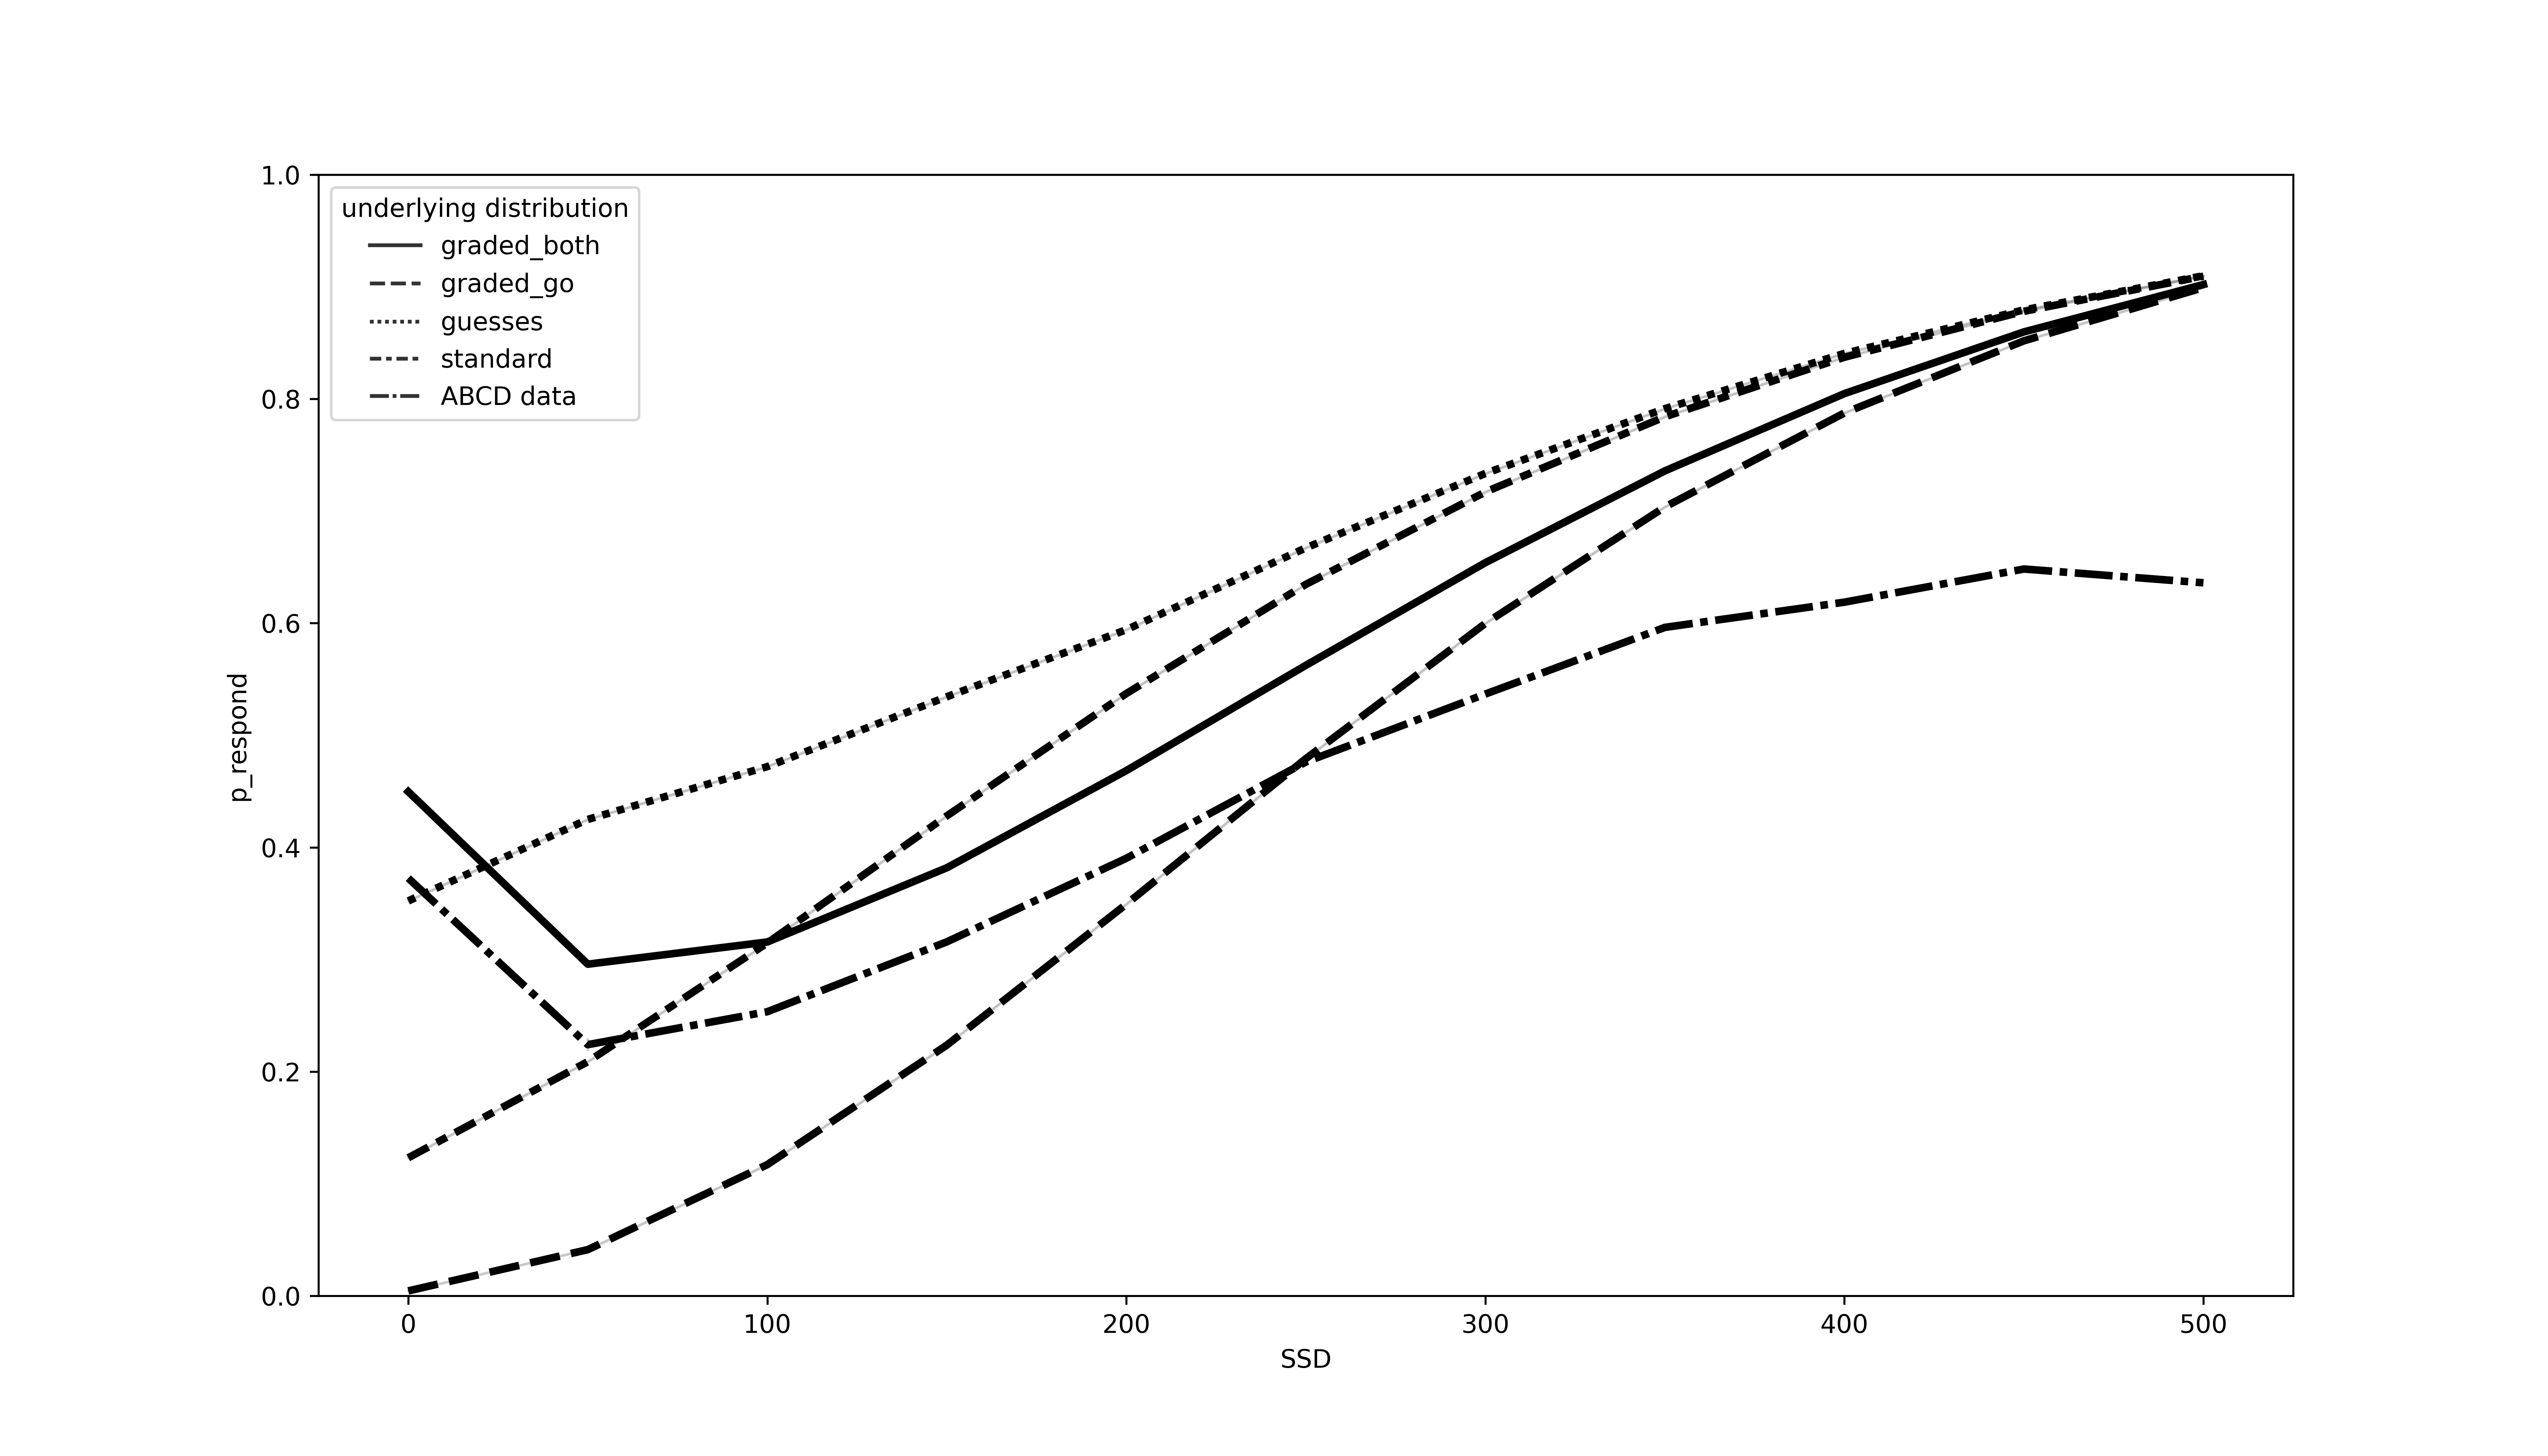

In [5]:
Image('figures/%s/inhibition_function.png' % suffix)

# Individual Differences

In [6]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [7]:
ssrt_df = pd.read_csv('ssrt_metrics/expected_ssrts_%s.csv' % suffix, index_col=0)

# reformatting - was multiindex
ssrt_df.columns = [ f'gen-{gen}_SSRT-{ssrt}' for gen, ssrt in zip(ssrt_df.loc['underlying distribution', :].values, ssrt_df.columns)]
ssrt_df = ssrt_df.drop(['underlying distribution', 'NARGUID'])

for col in ssrt_df.columns:
    ssrt_df[col] = ssrt_df[col].astype(float)


## **kludge** - Dask seems to have struggled reading a single tracking-based SSRT from a single subject's SSRT csv; only for the single individual case (SSRTscale-0_RTscale-0). I have downloaded the csv and am reading in the value to the expected_ssrts csv here.

In [8]:
#check the 3 other columns to make sure there is no instance
ok_tracking_ssrts = ['gen-graded_both_SSRT-tracking', 'gen-graded_go_SSRT-tracking.1', 'gen-standard_SSRT-tracking.3']
for ok_col in ok_tracking_ssrts:
    assert sum(ssrt_df[ok_col].isnull())==0
    
# checking problem sub
problem_ssrt_col = 'gen-guesses_SSRT-tracking.2'
problem_row = ssrt_df[ssrt_df[problem_ssrt_col].isnull()]
if len(problem_row)==1:
    problem_sub = problem_row.index[0]
    problem_sub

    problem_sub_ssrt_df = pd.read_csv('ssrt_metrics/individual_metrics_SSRTscale-0_RTscale-0/guesses_%s.csv' % problem_sub, index_col=0)

    # add back in value
    ssrt_df.loc[problem_sub, problem_ssrt_col] = problem_sub_ssrt_df.loc[problem_sub_ssrt_df.SSD == np.inf, 'SSRT'].values[0]

#confirm kludge worked
assert sum(ssrt_df[problem_ssrt_col].isnull())==0

## Reading in assigned mus/ SSRTs and RTs for comparison

In [9]:
# getting expect SSRTs
mus_path = 'abcd_data/assigned_mus_%s.json' % suffix
with open(mus_path, 'r') as f:
    mus_dict = json.load(f)
    
mus_df = pd.DataFrame(mus_dict).T

In [10]:
mus_df.head()

goRT        go        SSRT      stop
003RTV85  545.743782  0.201717  301.339962  0.397867
007W6H7B  545.743782  0.201717  301.339962  0.397867
00CY2MDM  545.743782  0.201717  301.339962  0.397867
00HEV6HB  545.743782  0.201717  301.339962  0.397867
00J52GPG  545.743782  0.201717  301.339962  0.397867

In [11]:
monster_df = pd.concat([mus_df.add_prefix('assigned_'), ssrt_df], 1, sort=True)
monster_df.columns = [col.split('.')[0] for col in monster_df.columns]
monster_df = monster_df.loc[monster_df['gen-standard_SSRT-fixed'].notnull()]

In [12]:
monster_df.shape

(8207, 28)

In [13]:
def make_plot_square(ax):
    lowx, highx = ax.get_xlim()
    lowy, highy = ax.get_ylim()
    low = min(lowx, lowy)
    high = max(highx, highy)
    ax.set_xlim((low, high))
    ax.set_ylim((low, high))
    return ax

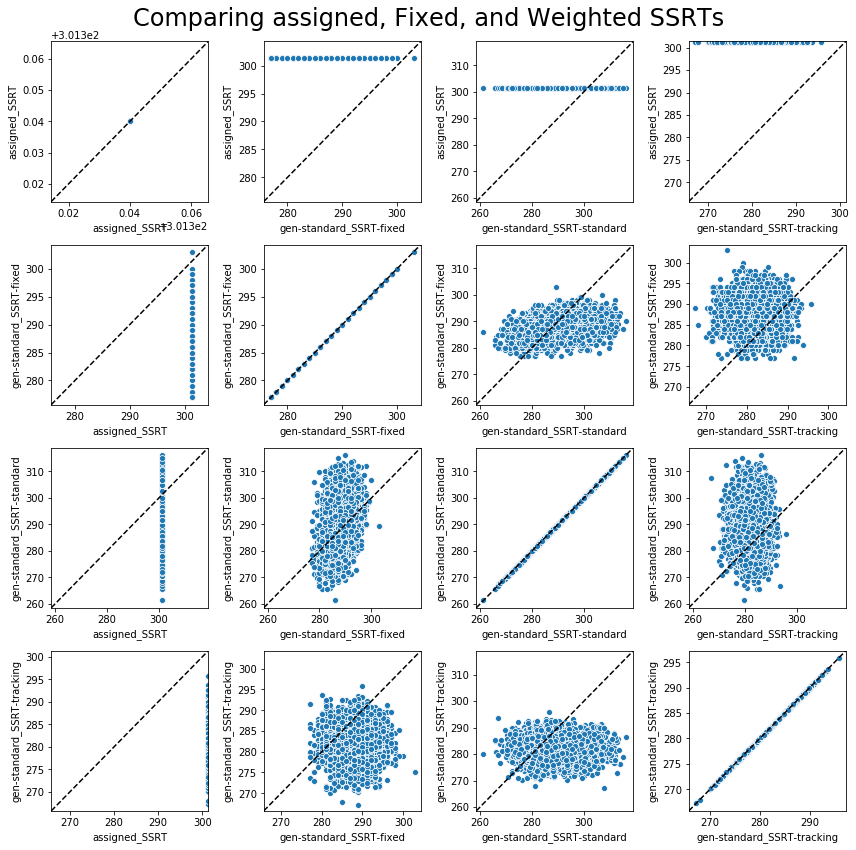

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

columns = ['assigned_SSRT', 'gen-standard_SSRT-fixed', 'gen-standard_SSRT-standard', 'gen-standard_SSRT-tracking']
for idx,coli in enumerate(columns):
    for jdx, colj in enumerate(columns):
        ax = sns.scatterplot(x=colj, y=coli, data=monster_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing assigned, Fixed, and Weighted SSRTs', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [15]:
monster_df[columns].corr(method='spearman')

assigned_SSRT  gen-standard_SSRT-fixed  \
assigned_SSRT                         NaN                      NaN   
gen-standard_SSRT-fixed               NaN                 1.000000   
gen-standard_SSRT-standard            NaN                 0.352782   
gen-standard_SSRT-tracking            NaN                -0.001289   

                            gen-standard_SSRT-standard  \
assigned_SSRT                                      NaN   
gen-standard_SSRT-fixed                       0.352782   
gen-standard_SSRT-standard                    1.000000   
gen-standard_SSRT-tracking                    0.007335   

                            gen-standard_SSRT-tracking  
assigned_SSRT                                      NaN  
gen-standard_SSRT-fixed                      -0.001289  
gen-standard_SSRT-standard                    0.007335  
gen-standard_SSRT-tracking                    1.000000

# Comparing Fixed SSRTs

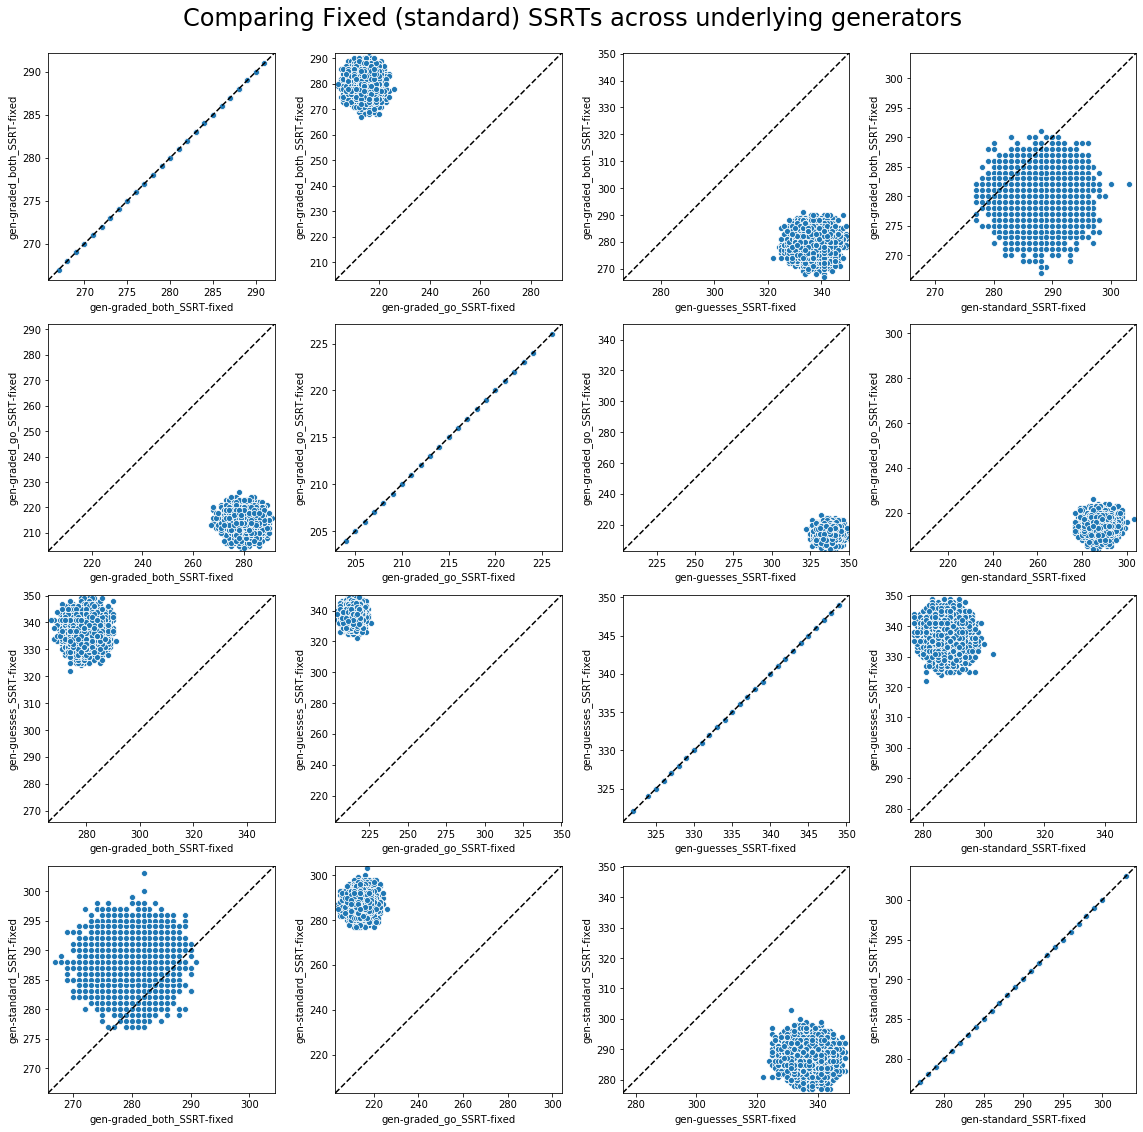

In [16]:
curr_df = monster_df.filter(regex='fixed')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [17]:
curr_df.corr(method='spearman')

gen-graded_both_SSRT-fixed  \
gen-graded_both_SSRT-fixed                    1.000000   
gen-graded_go_SSRT-fixed                      0.003930   
gen-guesses_SSRT-fixed                        0.017143   
gen-standard_SSRT-fixed                       0.008249   

                            gen-graded_go_SSRT-fixed  gen-guesses_SSRT-fixed  \
gen-graded_both_SSRT-fixed                  0.003930                0.017143   
gen-graded_go_SSRT-fixed                    1.000000               -0.005521   
gen-guesses_SSRT-fixed                     -0.005521                1.000000   
gen-standard_SSRT-fixed                     0.015849                0.012095   

                            gen-standard_SSRT-fixed  
gen-graded_both_SSRT-fixed                 0.008249  
gen-graded_go_SSRT-fixed                   0.015849  
gen-guesses_SSRT-fixed                     0.012095  
gen-standard_SSRT-fixed                    1.000000

## (not rescaling the axes to get a closer look)

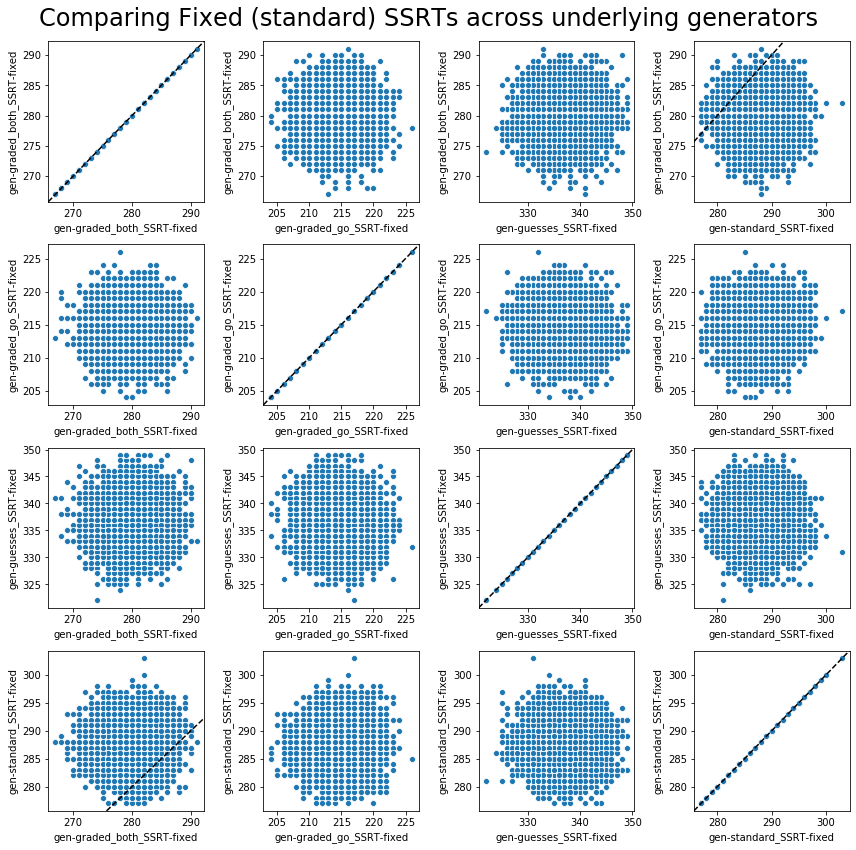

In [18]:
curr_df = monster_df.filter(regex='fixed')
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Weighted SSRTs (from randomly assigned SSD distributions)

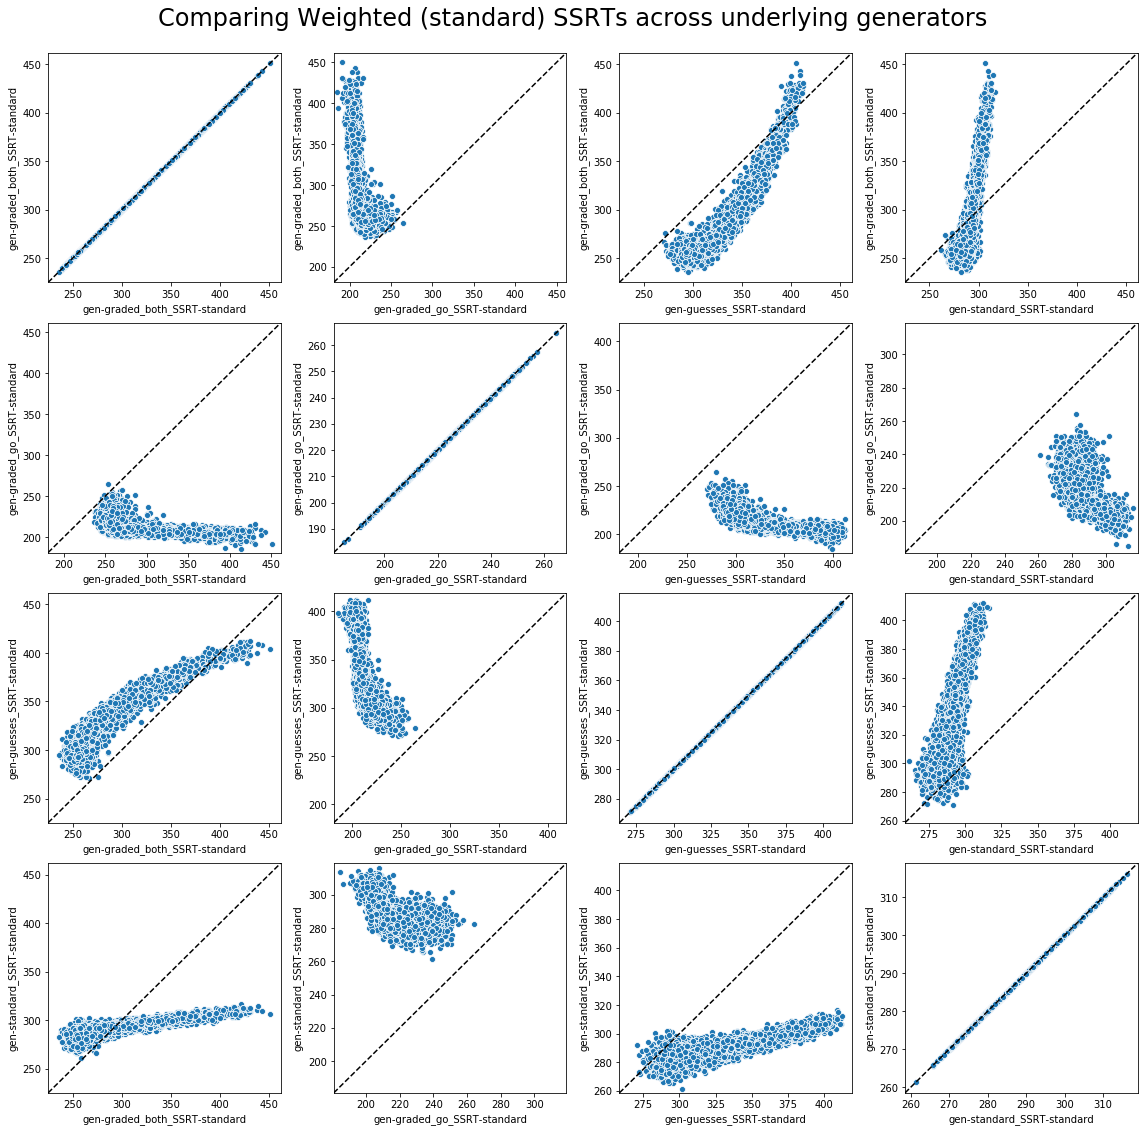

In [19]:
curr_df = monster_df.filter(regex='SSRT-standard')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [20]:
curr_df.corr(method='spearman')

gen-graded_both_SSRT-standard  \
gen-graded_both_SSRT-standard                       1.000000   
gen-graded_go_SSRT-standard                        -0.699939   
gen-guesses_SSRT-standard                           0.880510   
gen-standard_SSRT-standard                          0.733765   

                               gen-graded_go_SSRT-standard  \
gen-graded_both_SSRT-standard                    -0.699939   
gen-graded_go_SSRT-standard                       1.000000   
gen-guesses_SSRT-standard                        -0.845260   
gen-standard_SSRT-standard                       -0.642394   

                               gen-guesses_SSRT-standard  \
gen-graded_both_SSRT-standard                   0.880510   
gen-graded_go_SSRT-standard                    -0.845260   
gen-guesses_SSRT-standard                       1.000000   
gen-standard_SSRT-standard                      0.755709   

                               gen-standard_SSRT-standard  
gen-graded_both_SSRT-standard                    0.733765  
gen-graded_go_SSRT-standard                     -0.642394  
gen-guesses_SSRT-standard                        0.755709  
gen-standard_SSRT-standard                       1.000000

## not rescaling axis to get a closer look

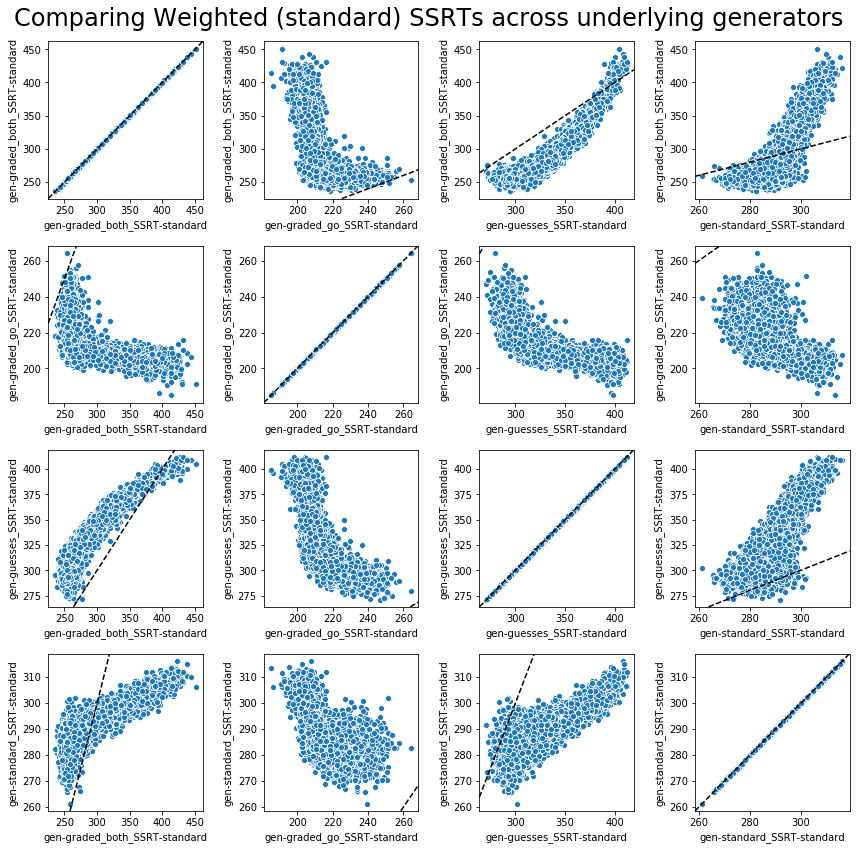

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Tracking-based SSRTs

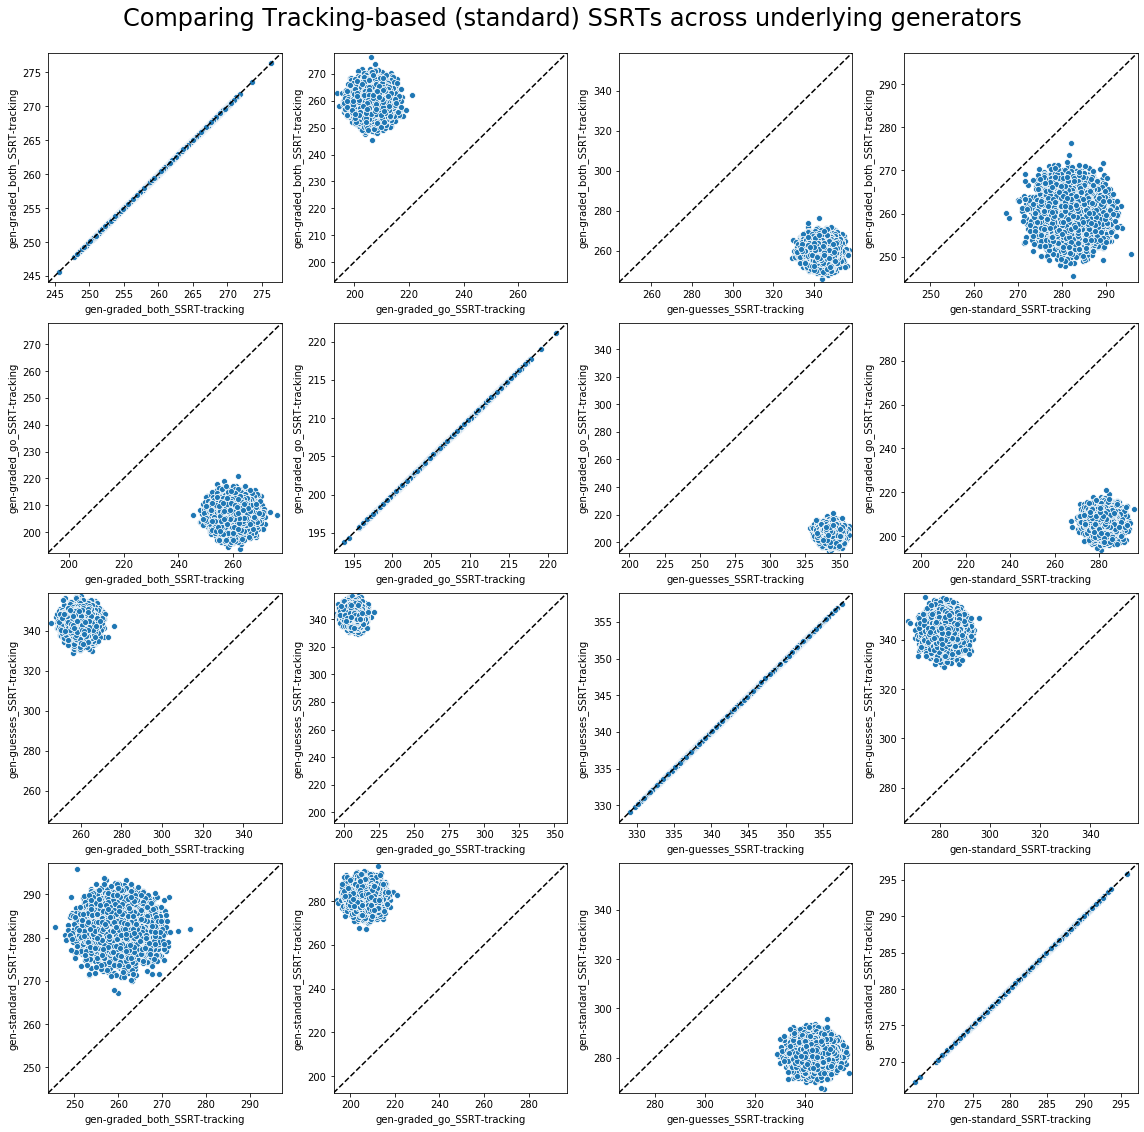

In [22]:
curr_df = monster_df.filter(regex='SSRT-tracking')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [23]:
curr_df.corr(method='spearman')

gen-graded_both_SSRT-tracking  \
gen-graded_both_SSRT-tracking                       1.000000   
gen-graded_go_SSRT-tracking                        -0.014700   
gen-guesses_SSRT-tracking                          -0.000471   
gen-standard_SSRT-tracking                         -0.017980   

                               gen-graded_go_SSRT-tracking  \
gen-graded_both_SSRT-tracking                    -0.014700   
gen-graded_go_SSRT-tracking                       1.000000   
gen-guesses_SSRT-tracking                        -0.011031   
gen-standard_SSRT-tracking                        0.011247   

                               gen-guesses_SSRT-tracking  \
gen-graded_both_SSRT-tracking                  -0.000471   
gen-graded_go_SSRT-tracking                    -0.011031   
gen-guesses_SSRT-tracking                       1.000000   
gen-standard_SSRT-tracking                      0.010623   

                               gen-standard_SSRT-tracking  
gen-graded_both_SSRT-tracking                   -0.017980  
gen-graded_go_SSRT-tracking                      0.011247  
gen-guesses_SSRT-tracking                        0.010623  
gen-standard_SSRT-tracking                       1.000000

## not rescaling axes

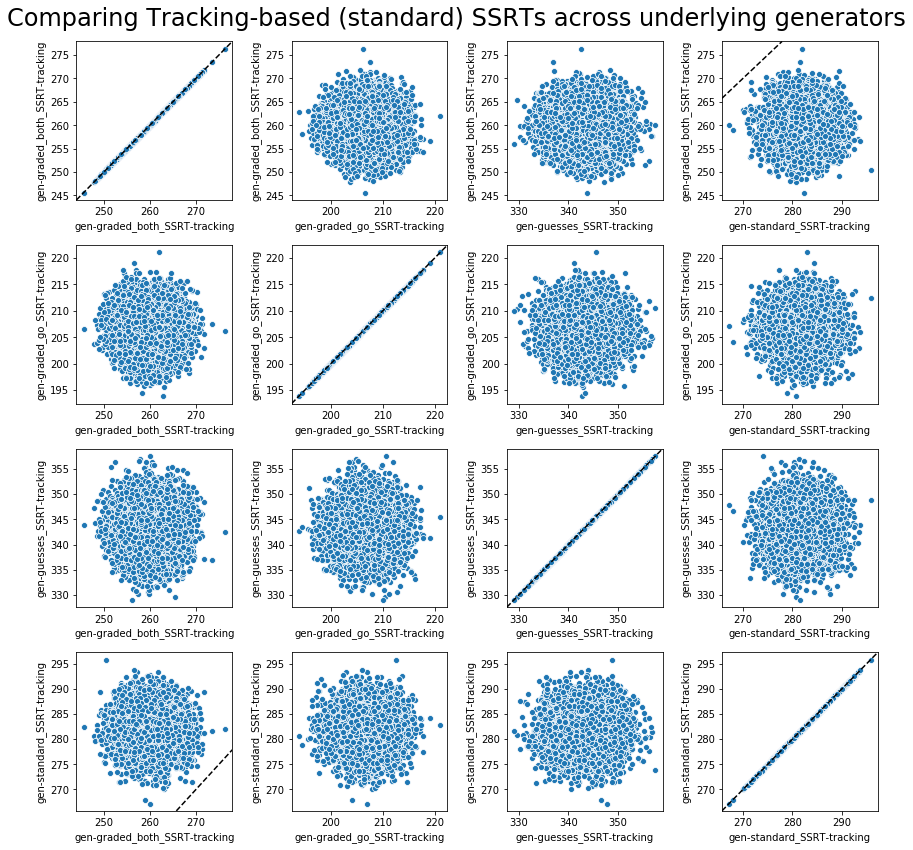

In [24]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [25]:
main_cols = ['assigned_SSRT',
             'gen-graded_both_SSRT-standard',
             'gen-graded_go_SSRT-standard',
             'gen-guesses_SSRT-standard',
             'gen-standard_SSRT-standard',
             'gen-graded_both_SSRT-fixed',
             'gen-graded_go_SSRT-fixed',
             'gen-guesses_SSRT-fixed',
             'gen-standard_SSRT-fixed',
             'gen-graded_both_SSRT-tracking',
             'gen-graded_go_SSRT-tracking',
             'gen-guesses_SSRT-tracking',
             'gen-standard_SSRT-tracking']
monster_df[main_cols].describe()

assigned_SSRT  gen-graded_both_SSRT-standard  \
count   8.207000e+03                    8207.000000   
mean    3.013400e+02                     279.892320   
std     8.299645e-12                      36.302694   
min     3.013400e+02                     235.916667   
25%     3.013400e+02                     255.485256   
50%     3.013400e+02                     264.300000   
75%     3.013400e+02                     292.433333   
max     3.013400e+02                     450.933333   

       gen-graded_go_SSRT-standard  gen-guesses_SSRT-standard  \
count                  8206.000000                8207.000000   
mean                    215.179784                 323.595174   
std                       9.671961                  28.534152   
min                     184.966667                 270.938776   
25%                     208.150000                 301.043557   
50%                     212.716667                 315.416667   
75%                     220.546121                 341.466667   
max                     264.452381                 412.000000   

       gen-standard_SSRT-standard  gen-graded_both_SSRT-fixed  \
count                 8207.000000                 8207.000000   
mean                   288.576515                  279.683197   
std                      7.413952                    3.295621   
min                    261.326531                  267.000000   
25%                    283.533333                  277.000000   
50%                    287.816667                  280.000000   
75%                    293.033333                  282.000000   
max                    316.200000                  291.000000   

       gen-graded_go_SSRT-fixed  gen-guesses_SSRT-fixed  \
count               8207.000000             8207.000000   
mean                 214.599123              336.594736   
std                    2.890965                3.776573   
min                  204.000000              322.000000   
25%                  213.000000              334.000000   
50%                  215.000000              337.000000   
75%                  217.000000              339.000000   
max                  226.000000              349.000000   

       gen-standard_SSRT-fixed  gen-graded_both_SSRT-tracking  \
count              8207.000000                     8207.00000   
mean                287.776898                      259.89024   
std                   3.386769                        3.71498   
min                 277.000000                      245.59000   
25%                 285.000000                      257.35700   
50%                 288.000000                      259.92000   
75%                 290.000000                      262.36900   
max                 303.000000                      276.32800   

       gen-graded_go_SSRT-tracking  gen-guesses_SSRT-tracking  \
count                  8207.000000                8207.000000   
mean                    206.800081                 343.190982   
std                       3.358781                   3.844246   
min                     193.806000                 329.060000   
25%                     204.570000                 340.629000   
50%                     206.820000                 343.152000   
75%                     209.049000                 345.793000   
max                     221.062000                 357.482000   

       gen-standard_SSRT-tracking  
count                 8207.000000  
mean                   281.839122  
std                      3.491719  
min                    267.194000  
25%                    279.459000  
50%                    281.822000  
75%                    284.180000  
max                    295.802000

In [26]:
ssrt_df.corr(method='spearman')

gen-graded_both_SSRT-standard  \
gen-graded_both_SSRT-standard                          1.000000   
gen-graded_go_SSRT-standard.1                         -0.699939   
gen-guesses_SSRT-standard.2                            0.880510   
gen-standard_SSRT-standard.3                           0.733765   
gen-graded_both_SSRT-guesses                           0.455160   
gen-graded_go_SSRT-guesses.1                          -0.866448   
gen-guesses_SSRT-guesses.2                             0.519711   
gen-standard_SSRT-guesses.3                           -0.877624   
gen-graded_both_SSRT-graded_go                         0.909357   
gen-graded_go_SSRT-graded_go.1                         0.757167   
gen-guesses_SSRT-graded_go.2                           0.888191   
gen-standard_SSRT-graded_go.3                          0.871697   
gen-graded_both_SSRT-graded_both                       0.909357   
gen-graded_go_SSRT-graded_both.1                       0.757167   
gen-guesses_SSRT-graded_both.2                         0.888191   
gen-standard_SSRT-graded_both.3                        0.871697   
gen-graded_both_SSRT-fixed                             0.132147   
gen-graded_go_SSRT-fixed.1                             0.005151   
gen-guesses_SSRT-fixed.2                               0.003145   
gen-standard_SSRT-fixed.3                              0.012546   
gen-graded_both_SSRT-tracking                         -0.002330   
gen-graded_go_SSRT-tracking.1                         -0.000325   
gen-guesses_SSRT-tracking.2                            0.014462   
gen-standard_SSRT-tracking.3                           0.013109   

                                  gen-graded_go_SSRT-standard.1  \
gen-graded_both_SSRT-standard                         -0.699939   
gen-graded_go_SSRT-standard.1                          1.000000   
gen-guesses_SSRT-standard.2                           -0.845260   
gen-standard_SSRT-standard.3                          -0.642394   
gen-graded_both_SSRT-guesses                           0.034303   
gen-graded_go_SSRT-guesses.1                           0.906543   
gen-guesses_SSRT-guesses.2                            -0.485140   
gen-standard_SSRT-guesses.3                            0.833356   
gen-graded_both_SSRT-graded_go                        -0.832959   
gen-graded_go_SSRT-graded_go.1                        -0.663240   
gen-guesses_SSRT-graded_go.2                          -0.861312   
gen-standard_SSRT-graded_go.3                         -0.874230   
gen-graded_both_SSRT-graded_both                      -0.832959   
gen-graded_go_SSRT-graded_both.1                      -0.663240   
gen-guesses_SSRT-graded_both.2                        -0.861312   
gen-standard_SSRT-graded_both.3                       -0.874230   
gen-graded_both_SSRT-fixed                             0.010593   
gen-graded_go_SSRT-fixed.1                             0.220972   
gen-guesses_SSRT-fixed.2                              -0.001991   
gen-standard_SSRT-fixed.3                              0.001928   
gen-graded_both_SSRT-tracking                          0.004970   
gen-graded_go_SSRT-tracking.1                          0.008233   
gen-guesses_SSRT-tracking.2                           -0.001172   
gen-standard_SSRT-tracking.3                           0.003741   

                                  gen-guesses_SSRT-standard.2  \
gen-graded_both_SSRT-standard                        0.880510   
gen-graded_go_SSRT-standard.1                       -0.845260   
gen-guesses_SSRT-standard.2                          1.000000   
gen-standard_SSRT-standard.3                         0.755709   
gen-graded_both_SSRT-guesses                         0.168639   
gen-graded_go_SSRT-guesses.1                        -0.970053   
gen-guesses_SSRT-guesses.2                           0.701106   
gen-standard_SSRT-guesses.3                         -0.948407   
gen-graded_both_SSRT-graded_go                       0.961710   
gen-graded_go_SSRT-graded_go.1  

## How many subs survived (i.e. didn't have non-null SSRTs)

This can occur during the weighted method if one of their SSD-specific SSRTs is null. Not sure if you want me to fix.

In [27]:
monster_df.columns

options = ['standard', 'guesses', 'graded_go', 'graded_both']

for gen_str in options:
    for ssrt_str in options:
        col = 'gen-%s_SSRT-%s' % (gen_str, ssrt_str)
        print(col, len(monster_df.loc[monster_df[col].notnull()]))

gen-standard_SSRT-standard 8207
gen-standard_SSRT-guesses 8207
gen-standard_SSRT-graded_go 8207
gen-standard_SSRT-graded_both 8207
gen-guesses_SSRT-standard 8207
gen-guesses_SSRT-guesses 8207
gen-guesses_SSRT-graded_go 8207
gen-guesses_SSRT-graded_both 8207
gen-graded_go_SSRT-standard 8206
gen-graded_go_SSRT-guesses 8206
gen-graded_go_SSRT-graded_go 8206
gen-graded_go_SSRT-graded_both 8206
gen-graded_both_SSRT-standard 8207
gen-graded_both_SSRT-guesses 8207
gen-graded_both_SSRT-graded_go 8207
gen-graded_both_SSRT-graded_both 8207


In [28]:
ssrt_df.filter(regex='SSRT-tracking').describe()

gen-graded_both_SSRT-tracking  gen-graded_go_SSRT-tracking.1  \
count                     8207.00000                    8207.000000   
mean                       259.89024                     206.800081   
std                          3.71498                       3.358781   
min                        245.59000                     193.806000   
25%                        257.35700                     204.570000   
50%                        259.92000                     206.820000   
75%                        262.36900                     209.049000   
max                        276.32800                     221.062000   

       gen-guesses_SSRT-tracking.2  gen-standard_SSRT-tracking.3  
count                  8207.000000                   8207.000000  
mean                    343.190982                    281.839122  
std                       3.844246                      3.491719  
min                     329.060000                    267.194000  
25%                     340.629000                    279.459000  
50%                     343.152000                    281.822000  
75%                     345.793000                    284.180000  
max                     357.482000                    295.802000

In [29]:
ssrt_df.filter(regex='SSRT-standard').describe()

gen-graded_both_SSRT-standard  gen-graded_go_SSRT-standard.1  \
count                    8207.000000                    8206.000000   
mean                      279.892320                     215.179784   
std                        36.302694                       9.671961   
min                       235.916667                     184.966667   
25%                       255.485256                     208.150000   
50%                       264.300000                     212.716667   
75%                       292.433333                     220.546121   
max                       450.933333                     264.452381   

       gen-guesses_SSRT-standard.2  gen-standard_SSRT-standard.3  
count                  8207.000000                   8207.000000  
mean                    323.595174                    288.576515  
std                      28.534152                      7.413952  
min                     270.938776                    261.326531  
25%                     301.043557                    283.533333  
50%                     315.416667                    287.816667  
75%                     341.466667                    293.033333  
max                     412.000000                    316.200000

In [30]:
ssrt_df.filter(regex='SSRT-fixed').describe()

gen-graded_both_SSRT-fixed  gen-graded_go_SSRT-fixed.1  \
count                 8207.000000                 8207.000000   
mean                   279.683197                  214.599123   
std                      3.295621                    2.890965   
min                    267.000000                  204.000000   
25%                    277.000000                  213.000000   
50%                    280.000000                  215.000000   
75%                    282.000000                  217.000000   
max                    291.000000                  226.000000   

       gen-guesses_SSRT-fixed.2  gen-standard_SSRT-fixed.3  
count               8207.000000                8207.000000  
mean                 336.594736                 287.776898  
std                    3.776573                   3.386769  
min                  322.000000                 277.000000  
25%                  334.000000                 285.000000  
50%                  337.000000                 288.000000  
75%                  339.000000                 290.000000  
max                  349.000000                 303.000000